# AQI Prediction Pipeline (48-hour Forecast)

This notebook implements a robust pipeline for predicting AQI (ISPU) for the next 48 hours using XGBoost and recursive forecasting.

## Key Improvements:
- **Feature Engineering**: Manual lags and rolling statistics.
- **Regularization**: XGBoost parameters tuned to prevent overfitting.
- **Recursive Forecasting**: Iterative prediction for multi-step forecasting.
- **Pipeline**: Modular structure for easier deployment.

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set plot style
sns.set(style="whitegrid")

## 1. Feature Engineering Setup

In [2]:
# Lag and rolling window configuration without classes
lags = [1, 2, 3, 6, 12, 24]
rolls = [3, 6, 12, 24]

## 2. Load and Preprocess Data

In [3]:
raw = pd.read_csv("synthetic_iot_data.csv")

rename_map = {
    "Timestamp": "timestamp",
    "PM2.5 density": "pm25_density",
    "Air quality level": "air_quality_level"
}
if "PM2.5 density" in raw.columns:
    raw = raw.rename(columns=rename_map)

raw["timestamp"] = pd.to_datetime(raw["timestamp"])
raw = raw.sort_values("timestamp").set_index("timestamp")

In [4]:
raw

,No,PM2.5 raw,pm25_density,PM10 density,air_quality_level,Temperature,Humidity,Pressure,Altitude estimate,Device ID
timestamp,,,,,,,,,,
2025-12-05 22:00:00,1,31.9,46.0,70.2,BAIK,26.7,73.9,940.1,624.6,10:B4:1D:E8:2E:E4
2025-12-05 22:00:30,2,5.8,7.8,9.8,BAIK,27.7,72.1,940.7,624.4,10:B4:1D:E8:2E:E4
2025-12-05 22:01:00,3,38.4,55.2,83.4,SEDANG,26.9,69.3,940.8,625.1,10:B4:1D:E8:2E:E4
2025-12-05 22:01:30,4,5.4,7.8,11.8,BAIK,27.1,75.1,940.7,624.9,10:B4:1D:E8:2E:E4
2025-12-05 22:02:00,5,15.5,19.1,24.3,BAIK,26.5,74.2,940.6,623.8,10:B4:1D:E8:2E:E4
...,...,...,...,...,...,...,...,...,...,...
2026-01-09 15:17:30,99996,8.9,10.2,13.5,BAIK,22.8,91.5,940.5,624.2,10:B4:1D:E8:2E:E4
2026-01-09 15:18:00,99997,1.5,2.1,3.0,BAIK,22.6,88.4,940.5,624.8,10:B4:1D:E8:2E:E4
2026-01-09 15:18:30,99998,5.9,7.3,10.2,BAIK,22.9,89.6,940.9,624.0,10:B4:1D:E8:2E:E4


In [5]:
if "aqi_ispu" not in raw.columns:
    x_points = np.array([0.0, 15.5, 55.4, 150.4, 250.4, 500.0])
    y_points = np.array([0, 50, 100, 200, 300, 500])
    raw["aqi_ispu"] = np.interp(raw["pm25_density"], x_points, y_points)

# Keep ONLY pm25_density and aqi_ispu columns
df = raw[["pm25_density", "aqi_ispu"]].resample("1H").mean().ffill()

print("Data loaded. Shape:", df.shape)
df.head()

Data loaded. Shape: (834, 2)


C:\Users\user\AppData\Local\Temp\ipykernel_37660\1664491367.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = raw[["pm25_density", "aqi_ispu"]].resample("1H").mean().ffill()


,pm25_density,aqi_ispu
timestamp,,
2025-12-05 22:00:00,16.836667,39.689015
2025-12-05 23:00:00,14.455833,37.121699
2025-12-06 00:00:00,12.944167,35.858726
2025-12-06 01:00:00,12.380833,35.442699
2025-12-06 02:00:00,13.680833,36.541648


In [6]:
a = df.copy()
for l in lags:
    a[f"aqi_lag_{l}"] = a["aqi_ispu"].shift(l)
    a[f"pm25_lag_{l}"] = a["pm25_density"].shift(l)

for r in rolls:
    a[f"aqi_roll_mean_{r}"] = a["aqi_ispu"].rolling(r).mean()
    a[f"aqi_roll_std_{r}"] = a["aqi_ispu"].rolling(r).std()

In [7]:
a

,pm25_density,aqi_ispu,aqi_lag_1,pm25_lag_1,aqi_lag_2,pm25_lag_2,aqi_lag_3,pm25_lag_3,aqi_lag_6,pm25_lag_6,...,aqi_lag_24,pm25_lag_24,aqi_roll_mean_3,aqi_roll_std_3,aqi_roll_mean_6,aqi_roll_std_6,aqi_roll_mean_12,aqi_roll_std_12,aqi_roll_mean_24,aqi_roll_std_24
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-12-05 22:00:00,16.836667,39.689015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05 23:00:00,14.455833,37.121699,39.689015,16.836667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 00:00:00,12.944167,35.858726,37.121699,14.455833,39.689015,16.836667,NaN,NaN,NaN,NaN,...,NaN,NaN,37.556480,1.951808,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 01:00:00,12.380833,35.442699,35.858726,12.944167,37.121699,14.455833,39.689015,16.836667,NaN,NaN,...,NaN,NaN,36.141041,0.874378,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 02:00:00,13.680833,36.541648,35.442699,12.380833,35.858726,12.944167,37.121699,14.455833,NaN,NaN,...,NaN,NaN,35.947691,0.554850,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-09 11:00:00,13.301667,35.429852,36.267437,12.840000,33.267014,12.188333,38.713076,15.148333,31.002079,11.054167,...,36.559270,13.579167,34.988101,1.548222,36.431911,1.918369,35.658510,2.477167,35.878116,2.048152
2026-01-09 12:00:00,13.873333,36.873544,35.429852,13.301667,36.267437,12.840000,33.267014,12.188333,37.303004,14.851667,...,36.836594,13.328333,36.190278,0.724933,36.360334,1.887125,35.856725,2.470755,35.879656,2.048918
2026-01-09 13:00:00,13.720833,36.375432,36.873544,13.873333,35.429852,13.301667,36.267437,12.840000,37.611081,14.156667,...,34.990246,12.645833,36.226276,0.733313,36.154392,1.788160,36.217393,2.160560,35.937372,2.042274


In [8]:
feature_df = df.copy()
feature_df["hour"] = feature_df.index.hour
feature_df["dayofweek"] = feature_df.index.dayofweek
feature_df["month"] = feature_df.index.month
feature_df["weekofyear"] = feature_df.index.isocalendar().week.astype(int)
feature_df["dayofyear"] = feature_df.index.dayofyear

# Display the updated feature_df with new columns
print("Feature DataFrame with new time-based features:")
feature_df.head()

Feature DataFrame with new time-based features:


,pm25_density,aqi_ispu,hour,dayofweek,month,weekofyear,dayofyear
timestamp,,,,,,,
2025-12-05 22:00:00,16.836667,39.689015,22,4,12,49,339
2025-12-05 23:00:00,14.455833,37.121699,23,4,12,49,339
2025-12-06 00:00:00,12.944167,35.858726,0,5,12,49,340
2025-12-06 01:00:00,12.380833,35.442699,1,5,12,49,340
2025-12-06 02:00:00,13.680833,36.541648,2,5,12,49,340


In [9]:
lags = [1, 2, 3, 6, 12, 24, 48]
rolls = [3, 6, 12, 24, 48]

for l in lags:
    feature_df[f"aqi_lag_{l}"] = feature_df["aqi_ispu"].shift(l)
    feature_df[f"pm25_lag_{l}"] = feature_df["pm25_density"].shift(l)

for r in rolls:
    feature_df[f"aqi_roll_mean_{r}"] = feature_df["aqi_ispu"].rolling(r).mean()
    feature_df[f"aqi_roll_std_{r}"] = feature_df["aqi_ispu"].rolling(r).std()

print("Feature engineering with new lags and rolling windows applied.")
feature_df.head()

Feature engineering with new lags and rolling windows applied.


,pm25_density,aqi_ispu,hour,dayofweek,month,weekofyear,dayofyear,aqi_lag_1,pm25_lag_1,aqi_lag_2,...,aqi_roll_mean_3,aqi_roll_std_3,aqi_roll_mean_6,aqi_roll_std_6,aqi_roll_mean_12,aqi_roll_std_12,aqi_roll_mean_24,aqi_roll_std_24,aqi_roll_mean_48,aqi_roll_std_48
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-12-05 22:00:00,16.836667,39.689015,22,4,12,49,339,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05 23:00:00,14.455833,37.121699,23,4,12,49,339,39.689015,16.836667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 00:00:00,12.944167,35.858726,0,5,12,49,340,37.121699,14.455833,39.689015,...,37.556480,1.951808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 01:00:00,12.380833,35.442699,1,5,12,49,340,35.858726,12.944167,37.121699,...,36.141041,0.874378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-06 02:00:00,13.680833,36.541648,2,5,12,49,340,35.442699,12.380833,35.858726,...,35.947691,0.554850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
feature_df = feature_df.dropna()

features = [c for c in feature_df.columns if c not in ["aqi_ispu", "pm25_density"]]
target = feature_df["aqi_ispu"]

print("Features and target defined. Shape of feature_df after dropping NaNs:", feature_df.shape)
print("Number of features:", len(features))


Features and target defined. Shape of feature_df after dropping NaNs: (786, 31)
Number of features: 29


## 3. Training with Regularization

In [11]:
X = feature_df[features]
y = target

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.5,
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

pipeline_data = {
    "model": model,
    "features": features,
    "lags": lags,
    "rolls": rolls
}
joblib.dump(pipeline_data, "aqi_pipeline_enhanced.pkl")
print("Pipeline saved to 'aqi_pipeline_enhanced.pkl'")

[0]	validation_0-rmse:2.07941	validation_1-rmse:1.94366
[100]	validation_0-rmse:0.65728	validation_1-rmse:0.88880
[200]	validation_0-rmse:0.34801	validation_1-rmse:0.72203
[300]	validation_0-rmse:0.23863	validation_1-rmse:0.66618
[400]	validation_0-rmse:0.18694	validation_1-rmse:0.64479
[500]	validation_0-rmse:0.16577	validation_1-rmse:0.63426
[600]	validation_0-rmse:0.16006	validation_1-rmse:0.63202
[695]	validation_0-rmse:0.15736	validation_1-rmse:0.63188

Model Evaluation:
RMSE: 0.6310
MAE: 0.4333
R2 Score: 0.8990
Pipeline saved to 'aqi_pipeline_enhanced.pkl'


In [12]:
feature_df

,pm25_density,aqi_ispu,hour,dayofweek,month,weekofyear,dayofyear,aqi_lag_1,pm25_lag_1,aqi_lag_2,...,aqi_roll_mean_3,aqi_roll_std_3,aqi_roll_mean_6,aqi_roll_std_6,aqi_roll_mean_12,aqi_roll_std_12,aqi_roll_mean_24,aqi_roll_std_24,aqi_roll_mean_48,aqi_roll_std_48
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-12-07 22:00:00,9.991667,29.298475,22,6,12,49,341,36.258465,13.742500,33.669331,...,33.075423,3.517799,33.605830,2.951486,34.511917,2.984224,35.343966,2.768635,35.443604,2.255920
2025-12-07 23:00:00,12.825000,34.691597,23,6,12,49,341,29.298475,9.991667,36.258465,...,33.416179,3.651080,33.432318,2.829528,34.341805,2.903189,35.478367,2.647855,35.392977,2.244699
2025-12-08 00:00:00,13.672500,37.071266,0,0,12,50,342,34.691597,12.825000,29.298475,...,33.687112,3.982563,34.484248,2.810365,34.501148,3.002890,35.475828,2.646229,35.418238,2.256842
2025-12-08 01:00:00,12.105000,32.992430,1,0,12,50,342,37.071266,13.672500,34.691597,...,34.918431,2.048857,33.996927,2.765519,34.577833,2.946443,35.399015,2.691972,35.367191,2.283827
2025-12-08 02:00:00,12.500833,35.081000,2,0,12,50,342,32.992430,12.105000,37.071266,...,35.048232,2.039615,34.232205,2.791997,34.701472,2.932655,35.358637,2.689048,35.336761,2.277567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-09 11:00:00,13.301667,35.429852,11,4,1,2,9,36.267437,12.840000,33.267014,...,34.988101,1.548222,36.431911,1.918369,35.658510,2.477167,35.878116,2.048152,36.193317,2.003147
2026-01-09 12:00:00,13.873333,36.873544,12,4,1,2,9,35.429852,13.301667,36.267437,...,36.190278,0.724933,36.360334,1.887125,35.856725,2.470755,35.879656,2.048918,36.173477,1.991315
2026-01-09 13:00:00,13.720833,36.375432,13,4,1,2,9,36.873544,13.873333,35.429852,...,36.226276,0.733313,36.154392,1.788160,36.217393,2.160560,35.937372,2.042274,36.172451,1.991196


In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 628 entries, 2025-12-07 22:00:00 to 2026-01-03 01:00:00
Freq: h
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hour              628 non-null    int32  
 1   dayofweek         628 non-null    int32  
 2   month             628 non-null    int32  
 3   weekofyear        628 non-null    int32  
 4   dayofyear         628 non-null    int32  
 5   aqi_lag_1         628 non-null    float64
 6   pm25_lag_1        628 non-null    float64
 7   aqi_lag_2         628 non-null    float64
 8   pm25_lag_2        628 non-null    float64
 9   aqi_lag_3         628 non-null    float64
 10  pm25_lag_3        628 non-null    float64
 11  aqi_lag_6         628 non-null    float64
 12  pm25_lag_6        628 non-null    float64
 13  aqi_lag_12        628 non-null    float64
 14  pm25_lag_12       628 non-null    float64
 15  aqi_lag_24        628 non-null    float64
 16 

In [14]:
X_train.columns.to_list()

['hour',
 'dayofweek',
 'month',
 'weekofyear',
 'dayofyear',
 'aqi_lag_1',
 'pm25_lag_1',
 'aqi_lag_2',
 'pm25_lag_2',
 'aqi_lag_3',
 'pm25_lag_3',
 'aqi_lag_6',
 'pm25_lag_6',
 'aqi_lag_12',
 'pm25_lag_12',
 'aqi_lag_24',
 'pm25_lag_24',
 'aqi_lag_48',
 'pm25_lag_48',
 'aqi_roll_mean_3',
 'aqi_roll_std_3',
 'aqi_roll_mean_6',
 'aqi_roll_std_6',
 'aqi_roll_mean_12',
 'aqi_roll_std_12',
 'aqi_roll_mean_24',
 'aqi_roll_std_24',
 'aqi_roll_mean_48',
 'aqi_roll_std_48']

In [15]:
# evaluasi model untuk data training
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R2: {train_r2:.4f}")

Train RMSE: 0.1584
Train MAE: 0.1228
Train R2: 0.9944


## 4. Recursive Forecasting (48 Hours)

In [16]:
pipeline_data = joblib.load("aqi_pipeline_enhanced.pkl")
model = pipeline_data["model"]
features = pipeline_data["features"]
lags = pipeline_data["lags"]
rolls = pipeline_data["rolls"]

historical_data = df.copy()
max_lookback = max(max(lags), max(rolls)) + 1
current_df = historical_data.tail(max_lookback).copy()

future_predictions = []
future_timestamps = []

last_timestamp = current_df.index[-1]
print(f"\nStarting 48h forecast from {last_timestamp}...")

for i in range(1, 49):
    next_time = last_timestamp + timedelta(hours=i)
    next_row = pd.DataFrame(index=[next_time], columns=current_df.columns)
    next_row["pm25_density"] = current_df["pm25_density"].iloc[-1]
    temp_df = pd.concat([current_df, next_row])

    df_feat = temp_df.copy()
    df_feat["hour"] = df_feat.index.hour
    df_feat["dayofweek"] = df_feat.index.dayofweek
    df_feat["month"] = df_feat.index.month
    df_feat["weekofyear"] = df_feat.index.isocalendar().week.astype(int)
    df_feat["dayofyear"] = df_feat.index.dayofyear


    for l in lags:
        df_feat[f"aqi_lag_{l}"] = df_feat["aqi_ispu"].shift(l)
        df_feat[f"pm25_lag_{l}"] = df_feat["pm25_density"].shift(l)

    for r in rolls:
        df_feat[f"aqi_roll_mean_{r}"] = df_feat["aqi_ispu"].rolling(r).mean()
        df_feat[f"aqi_roll_std_{r}"] = df_feat["aqi_ispu"].rolling(r).std()

    df_feat = df_feat.dropna()

    X_next = df_feat.iloc[[-1]][features]
    pred_aqi = model.predict(X_next)[0]

    future_predictions.append(pred_aqi)
    future_timestamps.append(next_time)

    temp_df.loc[next_time, "aqi_ispu"] = pred_aqi
    current_df = temp_df

forecast = pd.DataFrame({"timestamp": future_timestamps, "pred_aqi": future_predictions}).set_index("timestamp")
forecast.head()


Starting 48h forecast from 2026-01-09 15:00:00...


C:\Users\user\AppData\Local\Temp\ipykernel_37660\935554248.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp_df = pd.concat([current_df, next_row])
C:\Users\user\AppData\Local\Temp\ipykernel_37660\935554248.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp_df = pd.concat([current_df, next_row])
C:\Users\user\AppData\Local\Temp\ipykernel_37660\935554248.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, th

,pred_aqi
timestamp,
2026-01-09 16:00:00,34.555458
2026-01-09 17:00:00,34.669174
2026-01-09 18:00:00,34.982159
2026-01-09 19:00:00,35.380970
2026-01-09 20:00:00,35.541363


In [17]:
# import uvicorn
# from fastapi import FastAPI
# from pydantic import BaseModel
# import pandas as pd
# import numpy as np
# import joblib
# from datetime import timedelta, datetime

# # Initialize FastAPI app
# app = FastAPI(title="AQI Prediction API")

# # Load the trained model and other necessary data
# try:
#     pipeline_data = joblib.load("aqi_pipeline_enhanced.pkl")
#     model = pipeline_data["model"]
#     features = pipeline_data["features"]
#     lags = pipeline_data["lags"]
#     rolls = pipeline_data["rolls"]
#     print("Model and pipeline data loaded successfully!")
# except Exception as e:
#     print(f"Error loading model or pipeline data: {e}")
#     # Exit or handle error appropriately if model cannot be loaded
#     model = None
#     features = []
#     lags = []
#     rolls = []

# # Store a small chunk of historical data for feature generation during prediction
# # This assumes `df` (the original processed dataframe) is available from earlier cells.
# # We need enough data to compute the required lags and rolling features.
# if 'df' in globals():
#     historical_data_for_api = df.copy()
# else:
#     # Fallback if df is not globally available, for example during direct API run
#     # In a real scenario, you might load a recent chunk of data from a database
#     # For this example, we'll create a dummy if df is not found, but it won't be accurate.
#     print("Warning: 'df' not found, creating dummy historical data. Predictions might be inaccurate.")
#     historical_data_for_api = pd.DataFrame({'pm25_density': [15.0]*50, 'aqi_ispu': [40.0]*50},
#                                           index=pd.date_range(end=datetime.now(), periods=50, freq='H'))

# # Define Input Data Model for FastAPI
# class AQIInput(BaseModel):
#     # For real-time prediction, the API typically receives the *latest* known values
#     # and then uses them to generate the next prediction. Lags/rolls are derived.
#     # For a recursive forecast like this, we'll simulate predicting the next hour
#     # based on the *last known point* from the historical data.
#     # The actual timestamp for which we want prediction will be inferred as next hour.
#     # If the user provides a specific timestamp, we'd adjust accordingly.
#     last_known_timestamp: datetime = datetime.now() - timedelta(hours=1)
#     last_known_pm25_density: float
#     last_known_aqi_ispu: float

# # Helper function to generate features for a single prediction point
# def generate_features_for_prediction(last_known_data: pd.Series, next_time: datetime, all_historical_data: pd.DataFrame, lags, rolls, features_list):
#     # Create a temporary DataFrame including the last known historical data
#     # and the new point to be predicted.
#     # We need enough historical context to compute all lags and rolling features.
#     # The 'all_historical_data' passed here should include sufficient prior data.

#     # Ensure the timestamp of the last known data is in the index for proper feature calculation
#     if not isinstance(last_known_data.name, datetime):
#         # Assuming last_known_data is just values, use its own timestamp as index for the series
#         last_known_data.name = next_time - timedelta(hours=1) # Adjust if needed

#     # Combine the relevant historical data with the new point to feature engineer
#     temp_historical = all_historical_data.loc[all_historical_data.index <= last_known_data.name].tail(max(max(lags), max(rolls)) + 1)

#     # Add the last known point if it's not already the very last in temp_historical
#     if temp_historical.empty or temp_historical.index[-1] != last_known_data.name:
#         temp_historical = pd.concat([temp_historical, last_known_data.to_frame().T])

#     # Create a DataFrame for the point to be predicted
#     next_point_df = pd.DataFrame([{'pm25_density': np.nan, 'aqi_ispu': np.nan}], index=[next_time])
#     df_for_feat_eng = pd.concat([temp_historical, next_point_df])

#     # Generate time-based features
#     df_for_feat_eng["hour"] = df_for_feat_eng.index.hour
#     df_for_feat_eng["dayofweek"] = df_for_feat_eng.index.dayofweek
#     df_for_feat_eng["month"] = df_for_feat_eng.index.month
#     df_for_feat_eng["weekofyear"] = df_for_feat_eng.index.isocalendar().week.astype(int)
#     df_for_feat_eng["dayofyear"] = df_for_feat_eng.index.dayofyear

#     # Generate lagged features
#     for l in lags:
#         df_for_feat_eng[f"aqi_lag_{l}"] = df_for_feat_eng["aqi_ispu"].shift(l)
#         df_for_feat_eng[f"pm25_lag_{l}"] = df_for_feat_eng["pm25_density"].shift(l)

#     # Generate rolling features
#     for r in rolls:
#         df_for_feat_eng[f"aqi_roll_mean_{r}"] = df_for_feat_eng["aqi_ispu"].rolling(r).mean()
#         df_for_feat_eng[f"aqi_roll_std_{r}"] = df_for_feat_eng["aqi_ispu"].rolling(r).std()

#     # Extract the features for the *last* row (the one to be predicted)
#     X_next_point = df_for_feat_eng.iloc[[-1]][features_list]

#     return X_next_point


# @app.get("/", summary="Health Check")
# async def root():
#     return {"message": "AQI Prediction API is running!"}


# @app.post("/predict", summary="Predict next AQI (1-hour ahead)")
# async def predict_aqi(input_data: AQIInput):
#     if model is None:
#         return {"error": "Model not loaded. Please check API startup logs."}

#     # Construct the last known data point as a pandas Series
#     last_known_data = pd.Series({
#         'pm25_density': input_data.last_known_pm25_density,
#         'aqi_ispu': input_data.last_known_aqi_ispu
#     }, name=input_data.last_known_timestamp)

#     # The timestamp for which we want to predict is 1 hour after the last known data
#     prediction_timestamp = input_data.last_known_timestamp + timedelta(hours=1)

#     # Generate features for prediction
#     X_predict = generate_features_for_prediction(last_known_data,
#                                                  prediction_timestamp,
#                                                  historical_data_for_api,
#                                                  lags, rolls, features)

#     # Make prediction
#     predicted_aqi = model.predict(X_predict)[0]

#     return {
#         "prediction_timestamp": prediction_timestamp.isoformat(),
#         "predicted_aqi_ispu": float(predicted_aqi)
#     }

## 5. Visualization

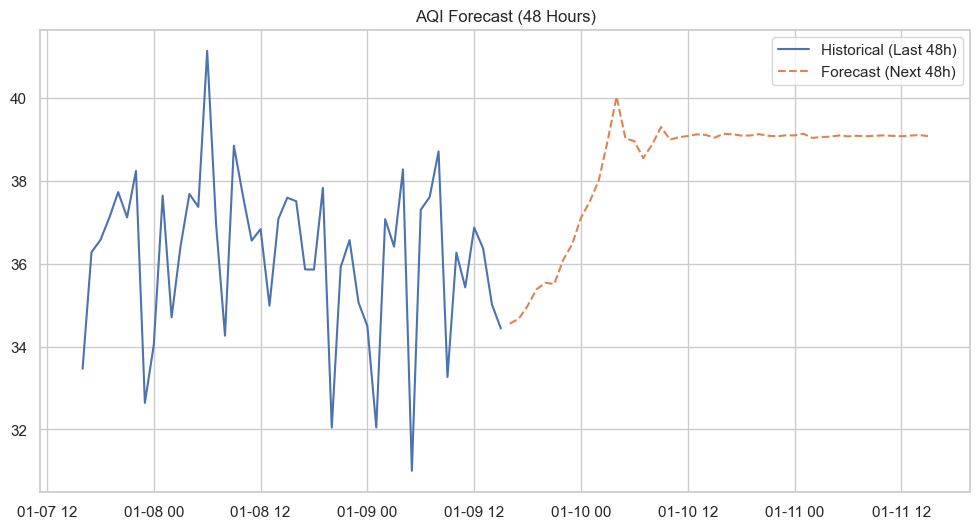

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-48:], df['aqi_ispu'].tail(48), label='Historical (Last 48h)')
plt.plot(forecast.index, forecast['pred_aqi'], label='Forecast (Next 48h)', linestyle='--')
plt.title("AQI Forecast (48 Hours)")
plt.legend()
plt.show()